In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [4]:
print(df.head())
df.columns = ['Production']
print(df.head())

            IPN31152N
DATE                 
1972-01-01    59.9622
1972-02-01    67.0605
1972-03-01    74.2350
1972-04-01    78.1120
1972-05-01    84.7636
            Production
DATE                  
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636


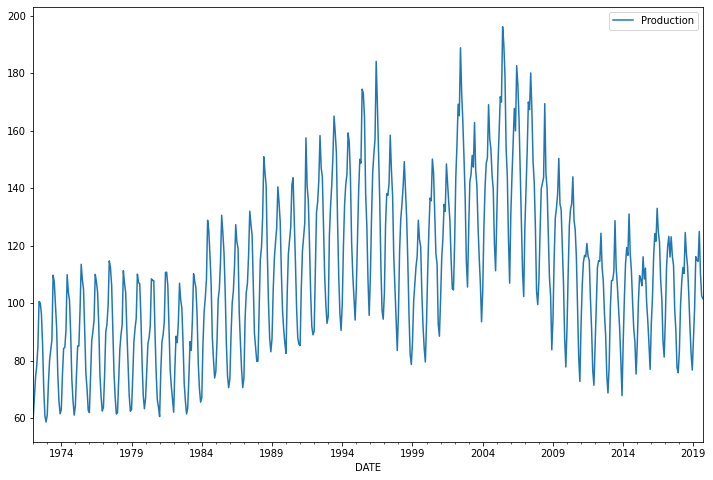

In [5]:
df.plot(figsize=(12,8))

In [6]:
print(len(df))
test_size = 24
test_ind = len(df)- test_size

573


In [8]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
print(len(test))

24


In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [14]:
#length at least 12 to capture the whole seasonality
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [16]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [18]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
531/531 [==============================] - 5s 8ms/step - loss: 0.0269 - val_loss: 0.0046
Epoch 2/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0106 - val_loss: 0.0018
Epoch 3/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0059 - val_loss: 0.0021
Epoch 4/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 5/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 6/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 7/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 8/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0031 - val_loss: 0.0053


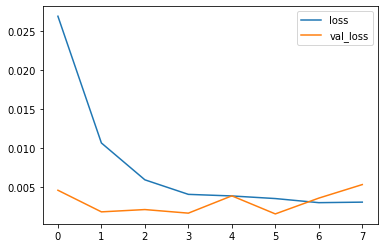

In [22]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [23]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [24]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
print(test.head())

            Production  Predictions
DATE                               
2017-10-01     90.4732    94.296523
2017-11-01     77.4378    89.305219
2017-12-01     75.8118    88.304159
2018-01-01     83.4343    97.405340
2018-02-01     99.4899   110.696543


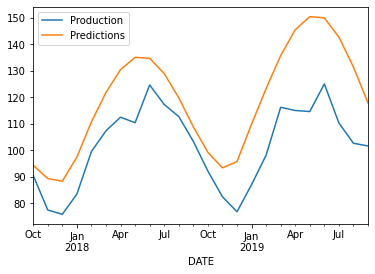

In [27]:
test.plot()

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
#calculate rmse
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

19.484178611986874